# Likelihood and Nested Sampling 

In this notebook I try to use the nested sampling to recover the posterior distribution of the parameters of the binary system. 

## Nested sampling basis

It's a very new form of algorithm that returns the evidence. More specifically:

- It explores the prior by extracting some points; 
- It ranks them base on the likelihood; 
- The lowest ranked point is removed aand we add a higher one.

The points are saved with weights $w_i$. The update of the least ranked point ($w_{\mathrm{least}}$) is done through some MCMC according to the prior, accepting only steps that keep the likelihood above the original $L_{\mathrm{least}}$. 

- The cluster of points climbs up the likelihood accumulating Bayesian evidence information along the way.

## On the priors

The prior choice is not always easy to do. It depends on how the expectations are: let's see some examples.

- If you want to probe the chirp mass for example, and you know $M_{\mathrm{chirp}} \simeq 400$, you can set your prior knowledge to be from $0$ to $1000$. Each point has the same weight in this prior, and so it is clear it's an appropriate choice. Generally, a standard uniform distribution is the following: 

$$f(x, a, b) = \cases{1 \ \text{if} \ x \in [a, b]\\ 
0 \ \text{elsewhere}}$$

- If you instead want to probe the accretion disk parameters, for example the $\Sigma_0$ normallization, it is clear you might want to see if this number is compatible with $0$, and this completely changes the kind of distribution you choose. A log-prior distribution could do the job: 

$$f(x, a, b) = \frac{1}{\log(\frac{b}{a}) \cdot x}$$

This distribution is uniform in log-scale, but the points are weighted differently. 

In [1]:
import numpy as np
import scipy
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.interpolate import interp1d
from pydd.analysis import calculate_SNR, calculate_match_unnormd_fft, get_match_pads, loglikelihood_fft, loglikelihood_fft_data, calculate_match_unnormd_fft_data
from pydd.binary import (
    AccretionDisk,
    MSUN,
    PC,
    Phi_to_c,
    get_c_f,
    _Phi_to_c_indef,
    VacuumBinary,
    convert,
    get_M_chirp,
    get_f_isco,
    get_f_range,
    get_m_1,
    make_vacuum_binary,
    t_to_c,
    YR,
    amp,
    d2Phi_dt2,
    G,
    C,
    Psi,
    restricted_hypgeom,
    h_0,
    _Phi_to_c_indef
)

import pickle
from typing import Tuple

import dynesty
from dynesty import plotting as dyplot

from tqdm.auto import trange
import corner
from scipy.interpolate import griddata
from scipy.stats import scoreatpercentile

/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/pydd/binary.py:521: RuntimeWarning: invalid value encountered in log10
  vals_neg = np.log10(1 - hypgeom_scipy(-b_mg[::-1, :], z_mg))


In [2]:
plt.rcParams['agg.path.chunksize'] = 1000  # Set a larger value for chunksize
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["TimesNewRoman"]})
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["axes.labelsize"] = "11"

In [3]:
# Set detector
detector = "LISA"

In [4]:
# Set PSDs, choose observation time and SNR threshold (will set distance in signal system below)
if detector == "et":
    from pydd.noise import S_n_et as S_n, f_range_et as f_range_n  # ET

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Einstein Telescope"
elif detector == "ce":
    from pydd.noise import S_n_ce as S_n, f_range_ce as f_range_n  # CE

    T_OBS = 1 * YR
    SNR_THRESH = 12.0
    TITLE = "Cosmic Explorer"
elif detector == "aLIGO":
    from pydd.noise import S_n_aLIGO as S_n, f_range_aLIGO as f_range_n  # aLIGO

    T_OBS = 1 * YR 
    SNR_THRESH = 12.0
    TITLE = "aLIGO"
elif detector == "LISA":
    from pydd.noise import S_n_LISA as S_n, f_range_LISA as f_range_n  # LISA

    T_OBS = 1 * YR #seconds
    SNR_THRESH = 100.0
    TITLE = "LISA"

## Create fiducial template

In [5]:
def get_signal_system() -> Tuple[AccretionDisk, Tuple[float, float]]:
    """
    Creates an accretion disk with SNR and duration as set above for given detector.
    
    """
    M_1 = np.array(1e5 * MSUN) # kg
    M_2 = np.array(10 * MSUN) # kg
    M_CHIRP = get_M_chirp(M_1, M_2)
    Q = M_2 / M_1
    sigM2 = 1.58e10 # Sigma_0 * Mach^2 in kg/m^2
    TT_C = np.array(0.0) # time of coalescence
    F_C = get_f_isco(M_1)
    PHI_C = np.array(0.0) # phase at coalescence
    PN = 0 # zero means don't include PN effects
    _AD_D = AccretionDisk(PN,
        sigM2,
        -1, # torques act to speed up inspiral (choose 1 for opposite direction)
        get_M_chirp(M_1, M_2),
        M_2 / M_1,
        PHI_C,
        tT_c=TT_C,
        dL=np.array(100e6 * PC), # luminosity distance to source in metres, dummy fixed here
        f_c=get_f_isco(M_1),
    )

    # Frequency range and grids
    F_RANGE_D = get_f_range(_AD_D, T_OBS)
    FS = np.linspace(
        max(F_RANGE_D[0], f_range_n[0]), min(F_RANGE_D[1], f_range_n[1]), 50_000
    )

    # Get dL such that SNR is as set above
    _fn = lambda dL: calculate_SNR(
            AccretionDisk(_AD_D.PN,
                _AD_D.SigM2,
                _AD_D.inout,
                _AD_D.M_chirp,
                _AD_D.q,
                _AD_D.Phi_c,
                _AD_D.tT_c,
                dL,
                _AD_D.f_c,
            ),
            FS,
            S_n,
        )
    
    res = root_scalar(
        lambda dL: (_fn(dL) - SNR_THRESH), bracket=(0.1e6 * PC, 100000e6 * PC)
    )
    assert res.converged
    DL = res.root

    # Signal system
    AD_D = AccretionDisk(_AD_D.PN,
        _AD_D.SigM2,
        _AD_D.inout,
        _AD_D.M_chirp,
        _AD_D.q,
        _AD_D.Phi_c,
        _AD_D.tT_c,
        DL,
        _AD_D.f_c,
    )

    return AD_D, F_RANGE_D

In [6]:
AD_D, F_RANGE_D = get_signal_system()

FS = np.linspace(F_RANGE_D[0], F_RANGE_D[-1], 10_000)  # coarser grid

PAD_LOW, PAD_HIGH = get_match_pads(FS)  # padding for likelihood calculation

In [7]:
def get_frequency_noise(psd, fs):
    
    delta_f = fs[1] - fs[0]
    sigma = np.sqrt(psd(fs)/(4 * delta_f))
    not_zero = (sigma != 0)
    sigma_red = sigma[not_zero]
    noise_re = np.random.normal(0, sigma_red)
    noise_co = np.random.normal(0, sigma_red)

    noise_red = (1/np.sqrt(2)) * (noise_re + 1j * noise_co)

    noise = np.zeros(len(sigma), dtype=complex)
    noise[not_zero] = noise_red

    return noise

In [8]:
def waveform(params_h, fs, S_n):
    flen = len(fs)
    delta_f = fs[1] - fs[0]
    
    wf_h = amp(fs, params_h) * np.exp(1j * Psi(fs, params_h))
    noise = get_frequency_noise(S_n, fs)
    
    wf_h_noise = wf_h + noise
    
    return wf_h, noise, wf_h_noise

## Generate 'observation' (waveform + noise) either with above, or pull in data from elsewhere

In [9]:
#with open("file_name", "rb") as f:
#    obs = pickle.load(f)

In [10]:
#F_OBS = # pull in frequency grid from observation

In [11]:
#SIG_OBS = # pull in h (averaged over inclination angle) from observation

In [12]:
#signal = SIG_OBS 
signal = waveform(AD_D, FS, S_n)[0] # 0: noiseless, 1: noise-only, 2: noisy

# Functions for likelihood calculation

In [13]:
def calculate_SNR(params, fs, S_n=S_n):
    integrand = amp(fs, params) ** 2 / S_n(fs)
    return np.sqrt(4 * np.trapz(integrand, fs))

def calculate_match_unnormd_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Inner product of waveforms, maximized over Phi_c by taking absolute value
    and t_c using the fast Fourier transform.
    """
    df = fs[1] - fs[0]
    wf_h = amp(fs, params_h) * np.exp(1j * Psi(fs, params_h)) # h is the model/template
    wf_d = signal # d is the signal including noise
    Sns = S_n(fs)

    # Use IFFT trick to maximize over t_c. Ref: Maggiore's book, eq. 7.171.
    integrand = 4 * wf_h.conj() * wf_d / Sns * df 
    integrand_padded = np.concatenate((pad_low, integrand, pad_high))
    
    return np.abs(len(integrand_padded) * np.fft.ifft(integrand_padded)).max()


def loglikelihood_fft(
    params_h, params_d, fs, pad_low, pad_high, S_n=S_n
):
    """
    Log-likelihood for a signal from a binary params_d modeled using params_h,
    maximized over the distance to the binary, Phi_c and t_c (i.e., all
    extrinsic parameters).
    """
    # Waveform magnitude
    ip_hh = calculate_SNR(params_h, fs, S_n) ** 2
    # Inner product of waveforms, maximized over Phi_c by taking absolute value
    ip_hd = calculate_match_unnormd_fft(params_h, params_d, fs, pad_low, pad_high, S_n)
    # Maximize over distance
    return 1 / 2 * ip_hd ** 2 / ip_hh

## Check 'max' likelihood 

In [14]:
maxll = loglikelihood_fft(AD_D, AD_D, FS, PAD_LOW, PAD_HIGH)
print(maxll)

5004.880507287326


## Set up prior to sample from 

In [15]:
SigM2 = AD_D.SigM2
print('sigm_m2 value: ', SigM2)

sigm_m2 value:  15800000000.0


In [16]:
# symmetric priors around true value

true_value = np.array([AD_D.M_chirp, AD_D.SigM2])

prior = [5e-3 * MSUN, 5e-1 * SigM2] # kg/m**2

prior_list = np.array(prior)

print('true value list: ', true_value)
print('prior list: ', prior_list)

true value list:  [7.91640182e+32 1.58000000e+10]
prior list:  [9.94275e+27 7.90000e+09]


In [17]:
def ptform_log(u: np.ndarray) -> np.ndarray:
    """
    Maps [0, 1] to deviations away (in log space) from true values.
    """
    assert u.shape == (2,)
    
    v_m = np.array([np.log10((true_value + prior_list) / (true_value - prior_list))])
    
    return (v_m * u)


def unpack_log(x: np.ndarray) -> AccretionDisk:
    """
    Convenience function to unpack parameters into an accretion disk.
    """
    
    sample_param = np.zeros(2)
    sample_param = x
    
    choose_prior = np.zeros(2)
    choose_prior = prior_list

    Mc = (AD_D.M_chirp - choose_prior[0]) * 10**sample_param[0]
    q = AD_D.q
    m_1 = get_m_1(Mc, q)
    f_c = get_f_isco(m_1)
    SigM2 = (AD_D.SigM2 - choose_prior[1]) * 10**sample_param[1]
    PN = 0

    return AccretionDisk(PN, SigM2, -1, Mc, AD_D.q, AD_D.Phi_c, AD_D.tT_c, AD_D.dL, f_c)

def get_ll_fft_log(x: np.ndarray) -> np.ndarray:
    """
    Likelihood function
    """
    ad_h = unpack_log(x)
    return loglikelihood_fft(ad_h, AD_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [18]:
# uniform priors, don't run both this and log priors

def ptform(u: np.ndarray) -> np.ndarray:
    """
    Maps [0, 1] to deviations away (in log space) from true values.
    """
    assert u.shape == (2,)
    v_m = np.array([10]) # M_sun
    v_n = np.array([np.log10((true_value[1] + prior_list[1]) / (true_value[1] - prior_list[1]))])
    #print(np.array([2 * v_m * (u[0]-0.5), v_n * u[1]]).shape)
    return np.array([2 * v_m * (u[0]-0.5), v_n * u[1]]).reshape(2, )


def unpack(x: np.ndarray) -> AccretionDisk:
    """
    Convenience function to unpack parameters into a dark dress.
    """
    # unpack x extraction
    dMc = x[0]
    dSigM2 = x[1] 
    choose_prior = prior_list[1] # for log-prior
    
    Mc = AD_D.M_chirp + dMc * MSUN
    q = AD_D.q
    m_1 = get_m_1(Mc, q)
    f_c = get_f_isco(m_1)
    
    SigM2 = (AD_D.SigM2 - choose_prior) * 10**dSigM2
    
    PN = 0
    
    return AccretionDisk(PN, SigM2, -1, Mc, AD_D.q, AD_D.Phi_c, AD_D.tT_c, AD_D.dL, f_c)

def get_ll_fft(x: np.ndarray) -> np.ndarray:
    """
    Likelihood function
    """
    ad_h = unpack(x)
    return loglikelihood_fft(ad_h, AD_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [19]:
# uniform priors, don't run both this and log priors

def ptform1(u: np.ndarray) -> np.ndarray:
    """
    Maps [0, 1] to deviations away (in log space) from true values.
    """
    assert u.shape == (1,)
    v_n = np.array([np.log10((true_value[1] + prior_list[1]) / (true_value[1] - prior_list[1]))])
    return v_n * u


def unpack1(x: np.ndarray) -> AccretionDisk:
    """
    Convenience function to unpack parameters into a dark dress.
    """
    # unpack x extraction
    dSigM2 = x
    choose_prior = prior_list[1] # for log-prior
    
    Mc = AD_D.M_chirp
    q = AD_D.q
    m_1 = get_m_1(Mc, q)
    f_c = get_f_isco(m_1)
    
    SigM2 = (AD_D.SigM2 - choose_prior) * 10**dSigM2
    
    PN = 0
    
    return AccretionDisk(PN, SigM2, -1, AD_D.M_chirp, AD_D.q, AD_D.Phi_c, AD_D.tT_c, AD_D.dL, f_c)

def get_ll_fft1(x: np.ndarray) -> np.ndarray:
    """
    Likelihood function
    """
    ad_h = unpack1(x)
    return loglikelihood_fft(ad_h, AD_D, FS, PAD_LOW, PAD_HIGH, S_n)

# Likelihood scan

From the definition of the functions above we have two cases:

- $\textbf{Case 1)}$ Uniform prior: the sampling of points from the prior returns a number $x$ which is in $M_\odot$. The interval from which $x$ is extracted is given by the chosen width $v_m$ multiplied by a number from a $\textbf{standard}$ uniform distribution ([0, 1]) $u$, to which we subtracted $0.5$ to center the $\textbf{true value}$ on $0$. To convert the extraction into a chirp mass we do: 

$$\mathcal{M}_{c, i} = \mathcal{M}_{c, \mathrm{true}} + x \text{,}$$

where $x$ is in centimeters.

- $\textbf{Case 2)}$ Log prior: the sampling of points from the prior returns a number $x$ which is a $\textbf{dimensionless number}$. The interval from which $x$ is still the same but is converted in log space, so $v_m$ now is the chosen width in log units. Indeed, going into log space we see that it still has width $2 \mathrm{chosen width}$. Calling the width $w$, we can use $x$ and extract: 

$$\mathcal{M}_{c, i} = (\mathcal{M}_{c, \mathrm{true}} - w) \cdot 10^{x}\text{.}$$

Then, setting $\mathcal{M}_{c, i} = \mathcal{M}_{c, \mathrm{true}}$ we can extract the $x$ corresponding to the true value of $\mathcal{M}_{c, i}$: 

$$\bar{x} = \log\left(\frac{\mathcal{M}_{c, \mathrm{true}}}{\mathcal{M}_{c, \mathrm{true}} - w}\right)\text{.}$$

In [20]:
# set smaller prior range

prior_list_SEARCH = [5e-3 * MSUN, 7e-1 * SigM2] # kg/m**2

def ptform_SEARCH(u: np.ndarray) -> np.ndarray:
    """
    Maps [0, 1] to deviations away (in log space) from true values.
    """
    assert u.shape == (2,)
    v_m = np.array([0.005]) # M_sun
    v_n = np.array([np.log10((true_value[1] + prior_list_SEARCH[1]) / (true_value[1] - prior_list_SEARCH[1]))])
    #print(np.array([2 * v_m * (u[0]-0.5), v_n * u[1]]).shape)
    return np.array([2 * v_m * (u[0]-0.5), v_n * u[1]]).reshape(2, )


def unpack_SEARCH(x: np.ndarray) -> AccretionDisk:
    """
    Convenience function to unpack parameters into a dark dress.
    """
    # unpack x extraction
    dMc = x[0]
    dSigM2 = x[1] 
    choose_prior = prior_list_SEARCH[1] # for log-prior
    
    Mc = AD_D.M_chirp + dMc * MSUN
    q = AD_D.q
    m_1 = get_m_1(Mc, q)
    f_c = get_f_isco(m_1)
    
    SigM2 = (AD_D.SigM2 - choose_prior) * 10**dSigM2
    
    PN = 0
    
    return AccretionDisk(PN, SigM2, -1, Mc, AD_D.q, AD_D.Phi_c, AD_D.tT_c, AD_D.dL, f_c)

def get_ll_fft_SEARCH(x: np.ndarray) -> np.ndarray:
    """
    Likelihood function
    """
    ad_h = unpack_SEARCH(x)
    return loglikelihood_fft(ad_h, AD_D, FS, PAD_LOW, PAD_HIGH, S_n)

In [21]:
xs = []
lls = []
for _ in trange(20000):
    xs.append(ptform_SEARCH(np.random.rand(2)))
    lls.append(get_ll_fft_SEARCH(xs[-1]))
              
xs = np.array(xs)
lls = np.array(lls)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [22]:
xs1 = []
lls1 = []
for _ in trange(5000):
    xs1.append(ptform1(np.random.rand(1)))
    lls1.append(get_ll_fft1(xs1[-1]))
              
xs1 = np.array(xs1)
lls1 = np.array(lls1)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [23]:
# Find true value for log prior

log_true = np.log10((true_value[1]) / (true_value[1] - prior_list[1]))
log_true_search = np.log10((true_value[1]) / (true_value[1] - prior_list_SEARCH[1]))

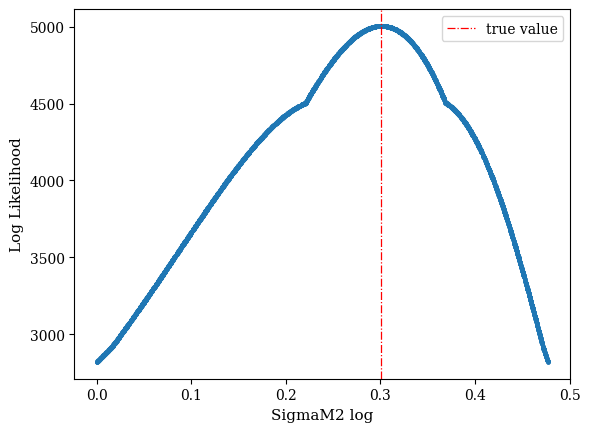

In [24]:
plt.scatter(xs1, lls1, s=5)
plt.axvline(x=log_true, label='true value', c='red', linestyle='-.', linewidth=0.9)
plt.xlabel('SigmaM2 log')
plt.ylabel('Log Likelihood')
plt.title('')
plt.legend();

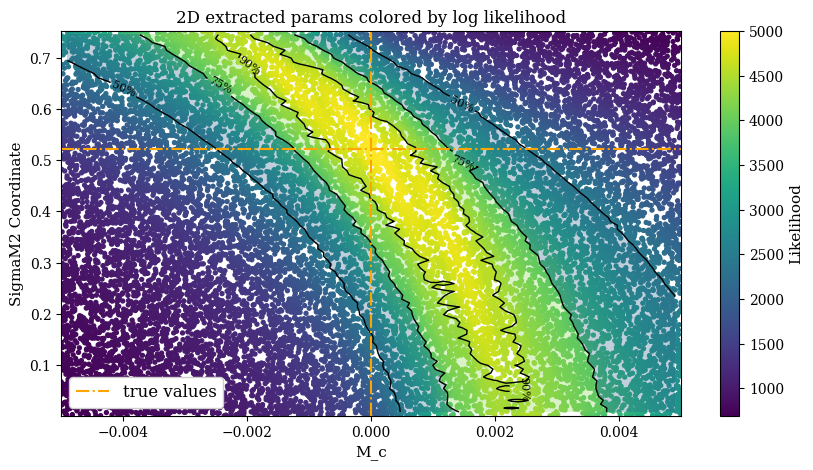

In [25]:
# Create a grid for contour plotting
grid_x, grid_y = np.mgrid[
    xs[:, 0].min():xs[:, 0].max():100j, 
    xs[:, 1].min():xs[:, 1].max():100j
]

# Interpolate log likelihood values on the grid
grid_lls = griddata((xs[:, 0], xs[:, 1]), lls, (grid_x, grid_y), method='cubic')

# Define the percentiles
percentiles = [50, 75, 90]

# Calculate the values at those percentiles
percentile_values = np.percentile(lls, percentiles)

# Create the plot
plt.figure(figsize=(10, 5))
sc = plt.scatter(xs[:, 0], xs[:, 1], c=lls, cmap='viridis', marker='o', s=8)
contour_lines = plt.contour(grid_x, grid_y, grid_lls, levels=percentile_values, linewidths=1, colors='black')
contour_fills = plt.contourf(grid_x, grid_y, grid_lls, levels=percentile_values, cmap='viridis', alpha=0.3)

# Add contour labels
fmt = {level: f'{percentiles[i]}%' for i, level in enumerate(percentile_values)}
plt.clabel(contour_lines, fmt=fmt, inline=True, fontsize=8, colors='black')

plt.axhline(y=log_true_search, label='true values', c='orange', linestyle='-.', linewidth=1.5)
plt.axvline(x=0, c='orange', linestyle='-.', linewidth=1.5)
cbar = plt.colorbar(sc, label='Likelihood')
plt.xlabel('M_c')
plt.ylabel('SigmaM2 Coordinate')
plt.title('2D extracted params colored by log likelihood')
plt.legend(loc='lower left', fontsize='large', framealpha=1)
plt.show()

## Nested Sampling

- $\textbf{Case 1)}$ Uniform prior for chirp:

In [26]:
# Initialize the nested sampler
# Use 500 - 2000 live points. You need a lot, otherwise you may miss the high-likelihood region!
sampler = dynesty.NestedSampler(get_ll_fft, ptform, 2, nlive=1000, bound='single')

# Run the nested sampling
sampler.run_nested(dlogz=1)  # dlogz is the threshold on the change in evidence that stops the run

# Extract the results
results_1d = sampler.results

16913it [18:16, 15.43it/s, +1000 | bound: 19 | nc: 1 | ncall: 65660 | eff(%): 27.703 | loglstar:   -inf < 5004.873 <    inf | logz: 4988.202 +/-  0.125 | dlogz:  0.001 >  1.000]


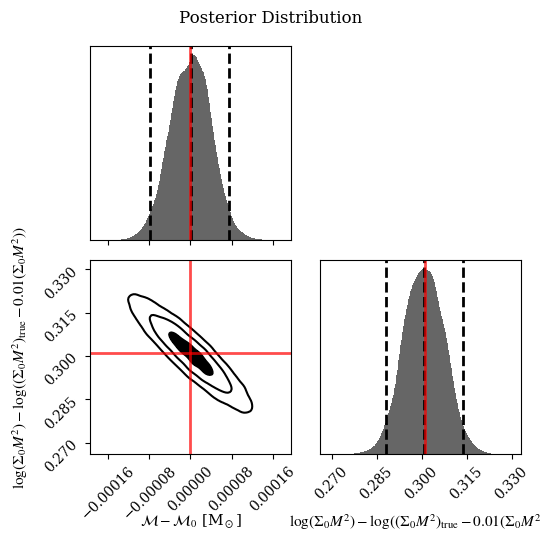

In [27]:
labels = [r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]", r"$\log(\Sigma_0 M^2) - \log((\Sigma_0 M^2)_{\mathrm{true}} - 0.01(\Sigma_0 M^2))$"]
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]

fig, axes = dyplot.cornerplot(
    results_1d, 
    labels=labels, 
    quantiles_2d=quantiles_2d, 
    truths=[0, log_true], 
    #verbose=True
)

fig.suptitle("Posterior Distribution")
plt.tight_layout()

plt.show()

# Convert the distributions into ones for $\mathcal{M}_c$ and $\Sigma_0 M^2$

In [28]:
import numpy as np

class CustomResults:
    def __init__(self, samples, log_weights):
        self.samples = samples
        self.logwt = log_weights

    def __getitem__(self, key):
        if key == 'samples':
            return self.samples
        elif key == 'logwt':
            return self.logwt
        else:
            raise KeyError(f"Invalid key '{key}'")

    def importance_weights(self):
        # Calculate importance weights for each set of samples based on log weights
        return np.exp(self.logwt - np.max(self.logwt))

    def __len__(self):
        # Return the number of sets of samples (number of rows)
        return self.samples.shape[0]

In [29]:
chirp_mass_posterior = results_1d.samples[:, 0]
sigma0_posterior = results_1d.samples[:, 1]
log_weights = results_1d.logwt

chirp_mass_posterior_transformed = (chirp_mass_posterior * MSUN + true_value[0]) / MSUN # in units of solar masses
sigma0_posterior_transformed = (true_value[1] * 10**(sigma0_posterior) - prior_list[1] * 10**(sigma0_posterior)) 

transformed_samples = np.vstack((chirp_mass_posterior_transformed, sigma0_posterior_transformed)).T

# Calculate log weights from results_1d 
log_weights = results_1d.logwt

# Instantiate custom results object
custom_results = CustomResults(transformed_samples, log_weights)

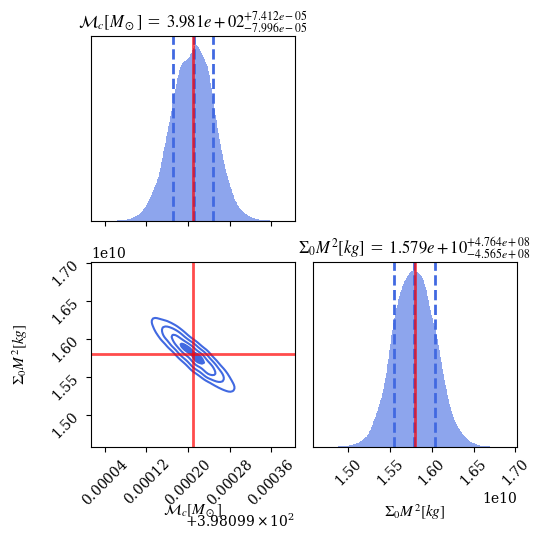

In [30]:
from matplotlib.ticker import ScalarFormatter

labels = [r"$\mathcal{M}_c [M_\odot]$", r"$\Sigma_0 M^2 [kg]$"]

# Plot using dyplot.cornerplot with custom results structure
fig, axes = dyplot.cornerplot(
    custom_results,
    labels=labels,
    show_titles=True,
    title_fmt=".3e",
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],
    truths=[true_value[0]/MSUN, true_value[1]],
    color='royalblue', 
    truth_color='red', 
)

# Customize the x-axis tick labels to scientific notation
axes[1, 0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

plt.tight_layout()
plt.show()

# What happens with noise?

## Likelihood scan

In [31]:
signal = waveform(AD_D, FS, S_n)[2]

In [32]:
xs_noise = []
lls_noise = []

for _ in trange(20000):
    xs_noise.append(ptform_SEARCH(np.random.rand(2)))
    lls_noise.append(get_ll_fft_SEARCH(xs_noise[-1]))
              
xs_noise = np.array(xs_noise)
lls_noise = np.array(lls_noise)

  0%|          | 0/20000 [00:00<?, ?it/s]

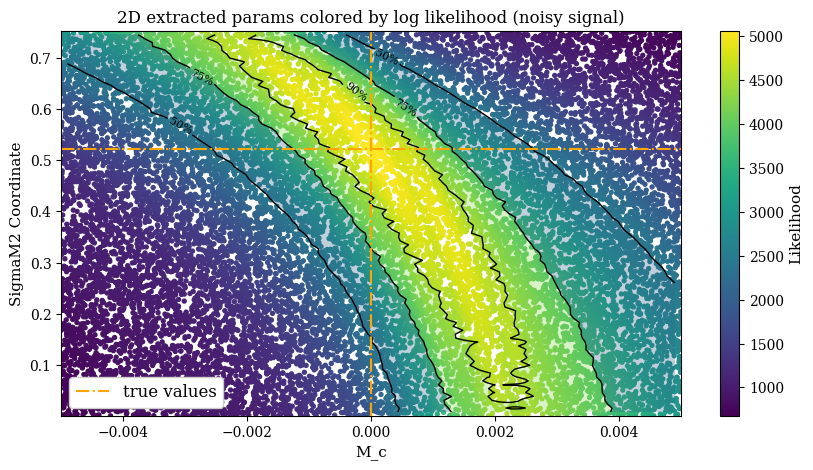

In [33]:
# Create a grid for contour plotting
grid_x, grid_y = np.mgrid[
    xs_noise[:, 0].min():xs_noise[:, 0].max():100j, 
    xs_noise[:, 1].min():xs_noise[:, 1].max():100j
]

# Interpolate log likelihood values on the grid
grid_lls = griddata((xs_noise[:, 0], xs_noise[:, 1]), lls_noise, (grid_x, grid_y), method='cubic')

# Define the percentiles
percentiles = [50, 75, 90]

# Calculate the values at those percentiles
percentile_values = np.percentile(lls, percentiles)

# Create the plot
plt.figure(figsize=(10, 5))
sc = plt.scatter(xs_noise[:, 0], xs_noise[:, 1], c=lls_noise, cmap='viridis', marker='o', s=8)
contour_lines = plt.contour(grid_x, grid_y, grid_lls, levels=percentile_values, linewidths=1, colors='black')
contour_fills = plt.contourf(grid_x, grid_y, grid_lls, levels=percentile_values, cmap='viridis', alpha=0.3)

# Add contour labels
fmt = {level: f'{percentiles[i]}%' for i, level in enumerate(percentile_values)}
plt.clabel(contour_lines, fmt=fmt, inline=True, fontsize=8, colors='black')

plt.axhline(y=log_true_search, label='true values', c='orange', linestyle='-.', linewidth=1.5)
plt.axvline(x=0, c='orange', linestyle='-.', linewidth=1.5)
cbar = plt.colorbar(sc, label='Likelihood')
plt.xlabel('M_c')
plt.ylabel('SigmaM2 Coordinate')
plt.title('2D extracted params colored by log likelihood (noisy signal)')
plt.legend(loc='lower left', fontsize='large', framealpha=1)
plt.show()

In [34]:
# Initialize the nested sampler
# Use 500 - 2000 live points. You need a lot, otherwise you may miss the high-likelihood region!
sampler1 = dynesty.NestedSampler(get_ll_fft, ptform, 2, nlive=1000, bound='single')

# Run the nested sampling
sampler1.run_nested(dlogz=1)  # dlogz is the threshold on the change in evidence that stops the run

# Extract the results
results_noisy = sampler1.results

17016it [18:40, 15.19it/s, +1000 | bound: 20 | nc: 1 | ncall: 64727 | eff(%): 28.271 | loglstar:   -inf < 5063.412 <    inf | logz: 5046.589 +/-  0.127 | dlogz:  0.001 >  1.000]


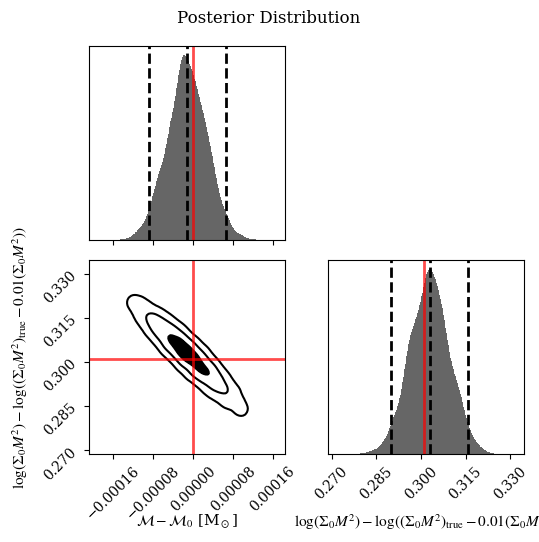

In [35]:
labels = [r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]", r"$\log(\Sigma_0 M^2) - \log((\Sigma_0 M^2)_{\mathrm{true}} - 0.01(\Sigma_0 M^2))$"]
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]

fig, axes = dyplot.cornerplot(
    results_noisy, 
    labels=labels, 
    quantiles_2d=quantiles_2d, 
    truths=[0, log_true], 
    #verbose=True
)

fig.suptitle("Posterior Distribution")
plt.tight_layout()

plt.show()

In [36]:
chirp_mass_posterior1 = results_noisy.samples[:, 0]
sigma0_posterior1 = results_noisy.samples[:, 1]
log_weights1 = results_noisy.logwt

chirp_mass_posterior_transformed1 = (chirp_mass_posterior1 * MSUN + true_value[0]) / MSUN # in units of solar masses
sigma0_posterior_transformed1 = (true_value[1] * 10**(sigma0_posterior1) - prior_list[1] * 10**(sigma0_posterior1)) 

transformed_samples1 = np.vstack((chirp_mass_posterior_transformed1, sigma0_posterior_transformed1)).T

# Calculate log weights from results_1d 
log_weights1 = results_noisy.logwt

# Instantiate custom results object
custom_results1 = CustomResults(transformed_samples1, log_weights1)

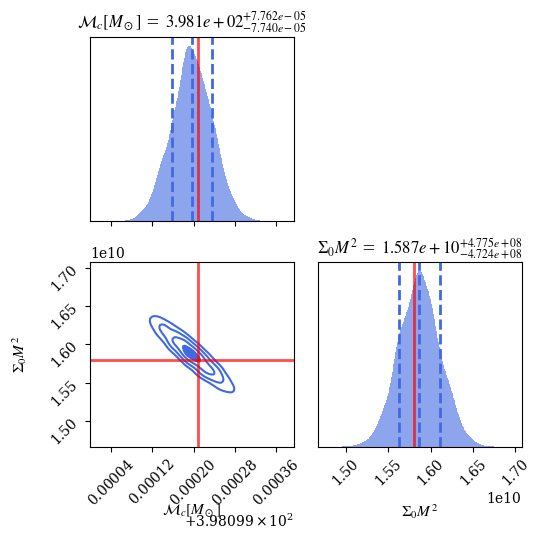

In [37]:
# Your labels and quantiles
labels = [r"$\mathcal{M}_c [M_\odot]$", r"$\Sigma_0 M^2$"]

# Plot using dyplot.cornerplot with custom results structure
fig, axes = dyplot.cornerplot(
    custom_results1,
    labels=labels,
    show_titles=True,
    title_fmt=".3e",
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],
    truths=[true_value[0]/MSUN, true_value[1]],
    color='royalblue', 
    truth_color='red', 
)

# Customize the x-axis tick labels to scientific notation
axes[1, 0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

plt.tight_layout()
plt.show()

It is slightly biased but it can happen as the noise has the effect of shifting the signal in ways that it could seem to have different generating parameters. 